# JEM092 Asset Pricing - Homework 1

### Group 82780095

Petr Dvořáček, Jan Kubal, Matyáš Mattanelli

---

Throughout the assignment we use the libraries loaded in the cell below. Some of them may need to be installed before running our code.

In [1]:
#install.packages(c("quantmod","rvest","stringr","xts","V8","PortfolioAnalytics","ROI.plugin.glpk","ROI.plugin.quadprog"))

In [2]:
#Loading the necessary libraries
suppressPackageStartupMessages({
    library(quantmod) #getSymbols function
    library(rvest) #Web scraping
    library(stringr) #Regular expressions
    library(xts) #Managing xts objects
    library(V8) #Evaluating html variables
    library(PortfolioAnalytics) #GMVP and efficient frontier
    library(ROI.plugin.glpk) #Portfolio optimization
    library(ROI.plugin.quadprog) #Portfolio optimization
})

## Task 1

In the first task we download the required data. We start by loading the csv file with the assigned tickers.

In [3]:
#Loading the assigned csv file
tickers_to_download <- read.csv("data_HW1/82780095_data_download.csv")
no_of_tickers <- nrow(tickers_to_download) #Storing the number of tickers for future use

#### Adjusted Close Price and Volume

We get the adjusted close price and volume daily data from Yahoo Finance using the ``getSymbols()`` function from the ``quantmod`` package.

In [4]:
#Downloading the data from Yahoo Finance (runtime 3m 15s)
yahoo_data_list <- vector("list", no_of_tickers) #Initializing an empty list for the data
options("getSymbols.warning4.0"=FALSE) #Command to prevent an annoying message from appearing
for (i in 1:no_of_tickers) { #Looping through the tickers
    yahoo_data_list[[i]] <- getSymbols(tickers_to_download[i, 2], src="yahoo", auto.assign = F, from = "2007-01-01", to = "2022-03-01")
}
#Saving the data so we do not have to download it every time we want to make changes
#saveRDS(yahoo_data_list, file = "list_yahoo.RData")

In [4]:
#In case of need, already downloaded data can be loaded for faster reading
#yahoo_data_list <- readRDS("list_yahoo.RData")

We stored the data for each ticker as an element of a list. Now we check that for each ticker we have volume in the 5th column and adjusted close price in the 6th column.

In [5]:
#Checking that we have adjusted close price and volume in appropriate columns for each ticker
check_col_name <- function(ticker_data, pattern, column_no) { #Defining a function to check if a column name matches a pattern
    ifelse(strsplit(names(ticker_data)[column_no], "\\.")[[1]][2] == pattern, return(T), return(F)) 
}
#Applying the function on all tickers for both Volume and Adjusted price
print(paste("Volume in the 5th column: ", sum(unlist(lapply(yahoo_data_list, check_col_name, pattern = "Volume", column_no = 5))), sep = ""), quote = F)
print(paste("Adjusted Close Price in the 6th column: ", sum(unlist(lapply(yahoo_data_list, check_col_name, pattern = "Adjusted", column_no = 6))), sep = ""), quote = F)

[1] Volume in the 5th column: 250
[1] Adjusted Close Price in the 6th column: 250


Since the check was successful, we can now merge the data for all tickers into a single xts object.

In [6]:
#Merging the available data into a single xts object
merged_yahoo_data <- merge.xts(yahoo_data_list[[1]][, 5:6], yahoo_data_list[[2]][, 5:6]) #Initial merge, adjusted close price and volume are in the 5th and 6th columns, respectively
for (iter in 3:no_of_tickers) { #Loop through the rest of the tickers and append each to the merged object
    merged_yahoo_data <- merge.xts(merged_yahoo_data, yahoo_data_list[[iter]][, 5:6])
}

We check that the number of columns is 500 (250 tickers and two columns for each ticker).

In [7]:
#Checking that the number of columns is correct
ncol(merged_yahoo_data) == no_of_tickers * 2 #Two columns for each ticker

[1] TRUE

#### Book Value per Share

Getting the Book value per share data is a bit more complex. Firstly, we find the company names with the help of the ``curlGetHeaders`` function. Then, we construct the urls.

In [10]:
#Getting the urls (runtime 1m47s)
urls_bv <- rep(NA, no_of_tickers) #Empty vector for the urls
for (iter in 1:no_of_tickers) { #Loop through all the tickers
    patt <- curlGetHeaders(paste0("https://www.macrotrends.net/stocks/charts/", tickers_to_download[iter, 2]))[5] #Save the response
    name_and_ticker <- str_extract(patt, paste0(tickers_to_download[iter, 2], "/.*/")) #Extract the relevant pattern from the string
    urls_bv[iter] <- paste0("https://www.macrotrends.net/stocks/charts/", name_and_ticker, "price-book") #Complete the url and save it
}
#Saving the data so we do not have to download it every time we want to make changes
#saveRDS(urls_bv, file = "urls_bv.RData")

In [11]:
#In case of need, already downloaded data can be loaded for faster reading
#urls_bv <- readRDS("urls_bv.RData")

Now that we have the urls, we can scrape the data. For each url we get the html code using the ``html_read`` function. Then we locate the table containing the data of interest. We loop through the rows to acquire the date and book value per share. We store the results as an xts object. Finally, we store the object for each ticker as an element of a list

In [12]:
#Downloading the data (runtime 3m6s)
bv_per_share_data <- vector("list", no_of_tickers) #Empty list to store the data
for (iter in 1:no_of_tickers) { #Loop through all tickers
  html_request <- read_html(urls_bv[iter]) #Sending the request
  trs <- html_request %>% 
    html_element("table") %>% #Finding the table
    html_element("tbody") %>% #FInding the body of the table
    html_elements("tr") #Finding the rows of the table
  dates <- rep(NA, length(trs)) #Empty vector to store the dates
  values <- rep(NA, length(trs)) #Empty vector to store the values
  for (iter2 in 1:length(trs)) { #Looping through all the rows
    tds <- html_elements(trs[iter2], "td") #Extracting the cells within each row
    dates[iter2] <- html_text(tds)[1] #First cell is the date
    values[iter2] <- as.numeric(gsub("\\$","",html_text(tds)[3])) #Third cell is book value per share
  }
  dates <- as.Date(dates) #Convert dates from string to Date format
  xts_object <- xts(x = values, order.by = dates) #Create an xts object from the results
  names(xts_object) <- paste0(tickers_to_download[iter, 2], ".BV_per_share") #Name it
  bv_per_share_data[[iter]] <-  xts_object #Store the results
}
#Saving the data so we do not have to download it every time we want to make changes
#saveRDS(bv_per_share_data, file = "bv_per_share_data.RData")

In [13]:
#In case of need, already downloaded data can be loaded for faster reading
#bv_per_share_data <- readRDS("bv_per_share_data.RData")

Similarly to the previous case, we simply merge the data into a single xts object. We should keep in mind that the data are quaterly. Since previously we downloaded daily data, we may have to make some adjustments in the future.

In [12]:
#Merging the individual tickers together
merged_bv_per_share_data <- merge.xts(bv_per_share_data[[1]], bv_per_share_data[[2]]) #Initial merge
for (iter in 3:no_of_tickers) {
    if (iter==72) {
        next #Temporarily skipping LUMN
    }
    merged_bv_per_share_data <- merge.xts(merged_bv_per_share_data, bv_per_share_data[[iter]])
}

#### Market Capitalization

Lastly, we download the market capitalization data. This time we have the direct url for each ticker. We get the html code and extract the script node from the body of the test. A quick inspenction revealed that the text contains a defined variable *chartData* that we can read using JavaScript. We convert the resulting data frame into an xts object and once again store it in a list.

In [13]:
#Downloading the data (runtime 1m34s)
market_cap_data <- vector("list", no_of_tickers)
for (iter in 1:no_of_tickers) { #Looping through all tickers
    html_request <- read_html(paste0("https://www.macrotrends.net/assets/php/market_cap.php?t=", tickers_to_download[iter, 2])) #Sending a request
    script <- html_request %>% #Extracting the relevant element and converting it to text
        html_element("body") %>%
        html_element("script") %>%
        html_text(trim = T)
    ctx <- v8() #The extracted text contains a variable which can be evaluated using JavaScript so we initialize an execution environment
    ctx$eval(str_extract(script,".*]")) #Evaluating the text. The function inside extracts the part that is relevant for us
    extracted_data <- ctx$get("chartData") #Extracting the variable (returns a data frame)
    xts_object <- xts(x = extracted_data[, 2], order.by = as.Date(extracted_data[, 1])) #Saving as an xts object
    names(xts_object) <- paste0(tickers_to_download[iter,2], ".Market_Cap") #Renaming
    market_cap_data[[iter]] <- xts_object #Storing
}
#Saving the data so we do not have to download it every time we want to make changes
#saveRDS(market_cap_data, file = "market_cap_data.RData")

In [14]:
#In case of need, already downloaded data can be loaded for faster reading
#market_cap_data <- readRDS("market_cap_data.RData")

Finally, we merge the acquired data into a single xts object.

In [15]:
#Merging the data
merged_market_cap_data <- merge.xts(market_cap_data[[1]], market_cap_data[[2]]) #Initial merge
for (iter in 3:no_of_tickers) { #Looping through all the tickers
    merged_market_cap_data <- merge.xts(merged_market_cap_data, market_cap_data[[iter]])
}

#### Merging it all together

In this step we merge all the acquired data together into a one xts object. Since we do not know the nature of the second assignment, we do not process the data any further. In case of need, we can use the separate RData files.

In [16]:
#Merging adjusted prices, volume, book value per share, and market capitalization
final_dataset <- merge.xts(merged_yahoo_data, merged_bv_per_share_data, merged_market_cap_data)

In [17]:
#Exporting to csv
#write.zoo(final_dataset, file = "final_dataset.csv", sep = ",")

## Task 2

In this task we form two porftolios and their corresponding efficient frontiers. We start by loading the ticker names that we are supposed to utilize.

In [18]:
#Loading the 20 tickers
tickers_20 <- read.csv("data_HW1/82780095_rand_download.csv")

To facilitate the subsetting in our data set, we find the row number for each ticker.

In [19]:
#Finding the row number for each ticker
iters <- rep(NA, 20)
for (i in 1:20) {   
    iters[i] <- tickers_to_download[tickers_to_download[, 2] == tickers_20[i, 2], 1]
}

Next, we extract the relevant tickers from the data we have acquired. Specifically, we need only the adjusted close price. We also restrict the period as required and convert the data from daily to monthly using the ``to.monthly()`` function.

In [34]:
#Getting data for the relevant tickers and adjusting it
task2_data <- vector("list", 20) #Empty list for the data
for (i in 1:20) { #Looping through the tickers
    task2_data[[i]] <- to.monthly(yahoo_data_list[[iters[i]]]["2014-12/", 6], OHLC = F) #Extracting data from 2015 and later and then converting it to monthly. Keeping only the Adjusted price 
}

From the resulting data we calculate returns using the adjusted close price and the following formula: $\frac{P_{i,t}-P_{i,t-1}}{P_{i,t-1}}$

In [36]:
#Converting to returns and merging into a single xts object
task2_data_returns <- vector("list", 20)
for (i in 1:20) {
    task2_data_returns[[i]] <- (task2_data[[i]] - lag(task2_data[[i]]))/lag(task2_data[[i]])
}
#Merging
final_returns <- merge.xts(task2_data_returns[[1]], task2_data_returns[[2]])
for (i in 3:20) {
    final_returns <- merge.xts(final_returns, task2_data_returns[[i]])
}
names(final_returns) <- gsub(".Adjusted", "", names(final_returns)) #Renaming for conciseness
final_returns <- final_returns["2015/"] #We keep only the data from 2015-2022

Since the data is ready, we can calculate the Global Minimum Variance Portoflio for both groups of tickers.

In [38]:
#Calculating the Global Minimum Variance Portfolios
#Portfolio A
pspecA <- portfolio.spec(assets = tickers_20[1:10, 2]) #Specifying the stock names
initial_portfolioA <- add.constraint(portfolio = pspecA, type = "full_investment") #Adding a constraint
minvarA <- add.objective(portfolio = initial_portfolioA, type = "risk", name = "var") #Adding an objective
opt_minvarA <- optimize.portfolio(R = final_returns[, 1:10], portfolio = minvarA, optimize_method = "ROI") #Optimizing
#Portfolio B
pspecB <- portfolio.spec(assets = tickers_20[11:20, 2]) #Specifying the stock names
initial_portfolioB <- add.constraint(portfolio = pspecB, type = "full_investment") #Adding a constraint
minvarB <- add.objective(portfolio = initial_portfolioB, type = "risk", name = "var") #Adding an objective
opt_minvarB <- optimize.portfolio(R = final_returns[, 11:20], portfolio = minvarB, optimize_method = "ROI") #Optimizing

Now we can construct the portfolios that we will use for forming the efficient frontier. We specify a box constraint with a minimum weight as the minimum of the weights from the respective GMVP and maximum weight equal to 1.

In [39]:
#Constructing portfolios A and B
pspec_fr_A <- portfolio.spec(assets = tickers_20[1:10, 2])
pspec_fr_B <- portfolio.spec(assets = tickers_20[11:20, 2])
portfolio_fr_A <- add.constraint(portfolio = pspec_fr_A, type = "box", min = min(opt_minvarA$weights), max = 1)
portfolio_fr_B <- add.constraint(portfolio = pspec_fr_B, type = "box", min = min(opt_minvarB$weights), max = 1)

For each of the portfolios, we form an efficient frontier.

In [40]:
#Creating the efficient frontier
eff_front_A <- create.EfficientFrontier(R = final_returns[, 1:10], portfolio = portfolio_fr_A, type = 'mean-var')
eff_front_B <- create.EfficientFrontier(R = final_returns[, 11:20], portfolio = portfolio_fr_B, type = 'mean-var')

Warning message:
"executing %dopar% sequentially: no parallel backend registered"


Lastly, we can plot the results. Firstly, we use ``char.EfficientFrontier`` to plot the frontier for portfolio A and then we manually add the data for the portfolio B. As we can see, the efficient frontier of the first portfolio lies entirely above the second frontier. Therefore, we would prefer any portfolio in the first frontier to any portfolio in the second frontier (with an exception of one portfolio where the frontiers intersect so we would be indifferent). For any given risk, the portfolio on the first efficient frontier yields higher (or equal) returns. In regards to some important stocks, we can see that IDXX and AAPL are way above the cluster of the other portfolios meaning that they have higher expected returns. In terms of risk they are roughly in the middle of the stocks. Therefore, they likely partially drive the shape of the portfolio A's efficient frontier. 

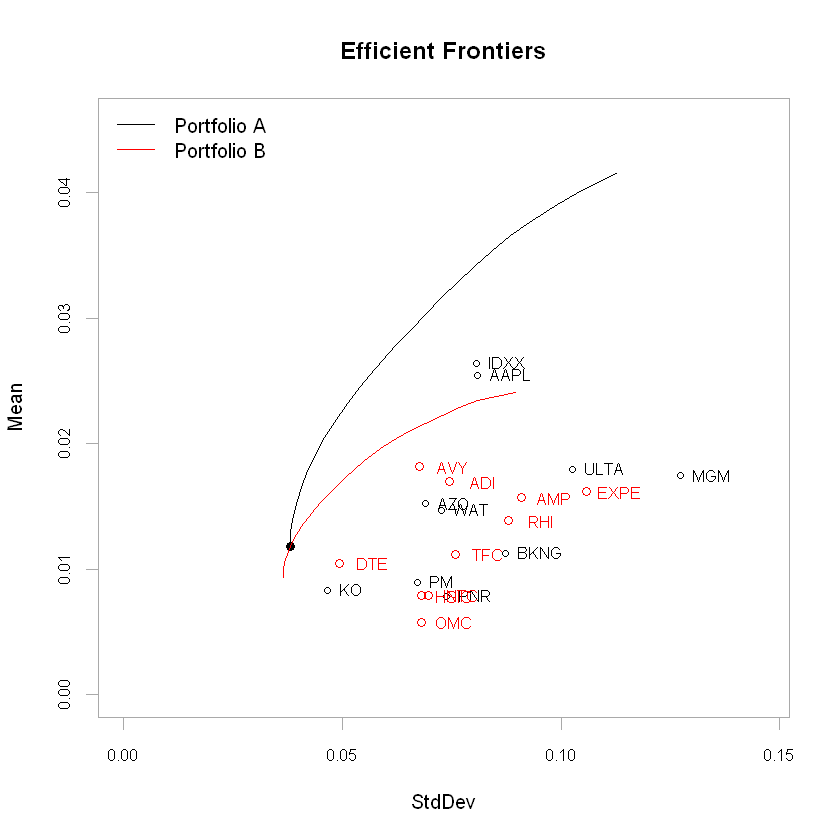

In [41]:
#Plotting the Efficient Frontier for portfolio A
chart.EfficientFrontier(eff_front_A, match.col = 'StdDev', type = 'l', tangent.line = FALSE, rf = NULL, main = "Efficient Frontiers")
#chart.EfficientFrontier(eff_front_B, match.col = 'StdDev', type = 'l', tangent.line = FALSE, rf = NULL)
#Adding the efficient frontier for portfolio B
lines(eff_front_B$frontier[, 2],eff_front_B$frontier[, 1], col = "red")
#Adding the individual assets from porfolio B
means <- apply(final_returns[, 11:20], 2, mean)
stdevs <- apply(final_returns[, 11:20], 2, sd)
points(stdevs, means, col = "red")
text(stdevs + 0.0075, means, labels = names(final_returns[, 11:20]), cex = 0.8, col = "red")
legend(x = "topleft", legend = c("Portfolio A", "Portfolio B"), col = c("black", "red"), lty = c(1, 1), bty = "n")

## Task 3

#### Simple Price Weighted Index

In the simple price weighted index, the weighting of each individual stock is equal to the current stock price of each constituent company divided by the sum of the stock prices of all the companies within the index. Movements of stocks with higher values (and higher weights in the portfolio) have greater impacts on the index than movements of stock with lower prices, therefore, it may be said that such indexes are price biased. 

To calculate the price weighted index, we first need to unadjust the close price from stock splits. As is stated at Yahoo Finance, the Close price is adjusted for stock splits but not for dividends (unlike adjusted close price), therefore, we only need one unadjustment. We download the information regarding stock splits from Yahoo Finance using the ``getSplits`` function.

In [42]:
#Downloading the information about stock splits
splits <- vector("list", 20) #Empty vector for the splits (the length is 20 since we do not know yet how many stocks undergone a stock split)
x <- 1 #Indexer to help us skip stocks with no splits
for (i in 1:20) { #Looping through the tickers
    suppressWarnings(split <- getSplits(tickers_20[i, 2], from = "2014-12-31", to = "2022-03-01")) #Get the split information
    if (sum(!is.na(split)) == 0) { #If there was no split, we do not need to store anything
        next
    } else {
        splits[[x]] <- split #If there is a split, store it
        x <- x + 1 #And increase the indexer
    }
}

Now we just merge the information into a single xts object

In [43]:
#Merging the stock split information
splits_merged <- merge.xts(splits[[1]], splits[[2]])
for (i in 3:20) {
    if (is.null(splits[[i]])) { #Stop when the vector is empty
        break
    } else {
        splits_merged <- merge.xts(splits_merged, splits[[i]])
    }
}

Since we have the splits information, we only need the close price. We have already downloaded it in Task 1.

In [47]:
#Taking the close prices from Task 1
task3_data_cl_pr <- vector("list", 20) #Empty list for the data
for (i in 1:20) { #Looping through the tickers
    task3_data_cl_pr[[i]] <- yahoo_data_list[[iters[i]]]["2015/", 4]
}

We have the daily close price which is adjusted for stock splits. Now, we will unadjust it using the ``adjRatios`` function which automatically calculates the ratios given the splits and close prices.

In [52]:
#Unadjusting the close price
for (i in 1:20) {
    if (tickers_20[i, 2] %in% unlist(str_split(names(splits_merged),"\\."))) { #Check if there was a split
        ratios <- adjRatios(splits = splits_merged[, paste0(tickers_20[i, 2], ".spl")], close = task3_data_cl_pr[[i]])[, 1] #Calculate the ratios
        task3_data_cl_pr[[i]] <- task3_data_cl_pr[[i]] / ratios #Unadjust
    }
}

We can also unadjust the close price for dividends:

In [ ]:
###Dividends
#dividends <- vector("list", 20) #Empty vector for the dividends
#y <- 1 #Indexer
#for (i in 1:20) { #Looping through the tickers
#  suppressWarnings(dividend <- getDividends(tickers_20[i, 2], from = "2014-12-31", to = "2022-03-01")) #Get the dividend information
#  if (sum(!is.na(dividend)) == 0) { #If there was no dividend, we do not need to store anything
#    next
#  } else {
#    dividends[[y]] <- dividend #If there is a dividend, store it
#    y <- y + 1
#  }
#}

#Merging the stock dividend information
#dividends_merged <- merge.xts(dividends[[1]], dividends[[2]])
#for (i in 3:20) {
#  if (is.null(dividends[[i]])) { #Stop when the vector is empty
#    break
#  } else {
#    dividends_merged <- merge.xts(dividends_merged, dividends[[i]])
#  }
#}

#Unadjusting the close price for dividends
#for (i in 1:20) {
#  if (tickers_20[i, 2] %in% unlist(str_split(names(dividends_merged),"\\."))) { #Check if there was a dividend
#    ratios <- adjRatios(dividends = dividends_merged[, paste0(tickers_20[i, 2], ".div")], close = task3_data_cl_pr[[i]])[, 1] #Calculate the ratios
#    task3_data_cl_pr[[i]] <- task3_data_cl_pr[[i]] / ratios #Unadjust
#  }
#}

Then, we will convert the daily prices to monthly and merge them into a single xts object.

In [59]:
#Converting to monthly and merging into a single xts object
task3_data_cl_pr_unadj <- merge.xts(to.monthly(task3_data_cl_pr[[1]], OHLC = F), to.monthly(task3_data_cl_pr[[2]], OHLC = F))
for (i in 3:20) {
    task3_data_cl_pr_unadj <- merge.xts(task3_data_cl_pr_unadj, to.monthly(task3_data_cl_pr[[i]], OHLC = F))
}

Lastly, since we have monthly data, we also need to convert the information about the splits to monthly. Even though the splits have not always appeared at the beginning of the month, we will assume so for simplicity.

In [75]:
#Converting splits to monthly
index(splits_merged) <- as.yearmon(index(splits_merged))

Since we have the data ready, we can calculate the index. We will use the formula given in the assignment: $PWI_t=\frac{\sum_{i=1}^N P_{i,t}}{divisor}$. The divisor has to be adjusted each time there is a stock split. Therefore, up until the first stock split, the divisor will be equal to the number of stocks which is 20 in our case. To calculate the new divisor after a stock split, we need to do the following. Firstly, we sum all the prices from the previous period except for the stock that undergone the split. Then, we add to this sum the price of the stock from the previous period multiplied by the stock ratio. The resulting number will be divided by the price index from the previous period and we get the new divisor.

In [156]:
#Calculating the index
no_of_months <- length(index(task3_data_cl_pr_unadj)) #Storing the number of periods
PWI <- xts(rep(NA, no_of_months), order.by = index(task3_data_cl_pr_unadj)) #Empty xts object for the index
names(PWI) <- "PWI" #Naming the column
divisor <- 20 #Initially, the divisor is equal to the number of stocks
for (i in 1:no_of_months) { #Looping through the periods
    if (index(task3_data_cl_pr_unadj)[i] %in% index(splits_merged)) { #Checking if a split occured
        stock <- str_split(names(splits_merged)[!is.na(splits_merged[index(task3_data_cl_pr_unadj)[i]])], "\\.")[[1]][1] #Identifying the stock that undergone the split
        stock_id <- tickers_20[tickers_20[, 2] == stock, 1] #Finding the id of the stock
        new_price <- as.numeric(task3_data_cl_pr_unadj[index(task3_data_cl_pr_unadj)[i - 1], paste0(stock,".Close")])*as.numeric(splits_merged[index(task3_data_cl_pr_unadj)[i], paste0(stock, ".spl")]) #Divide the price for the period before the stock split by the stock split ratio
        divisor <- (sum(task3_data_cl_pr_unadj[index(task3_data_cl_pr_unadj)[i - 1], setdiff(names(task3_data_cl_pr_unadj),paste0(stock, ".Close"))]) + new_price)/PWI[index(task3_data_cl_pr_unadj)[i - 1]] #Get the new divisor by summing the prices in the period before with the adjusted price and then dividing by the price index from the previous period
    }
    PWI[index(task3_data_cl_pr_unadj)[i]] <- sum(task3_data_cl_pr_unadj[index(task3_data_cl_pr_unadj)[i]])/as.numeric(divisor) #Calculate the index for the given period
}

#### Market-Capitalization Weighted Index

Also known as capitalization-weighted index or market value-weighted index market-capitalization weighted index is a type of stock market index in which individual components of the index are included in amounts that correspond to their total market capitalization. This index is believed to be the most common type of stock market index today, however, it suffers from market capitalization bias because stocks of larger companies (with higher market capitalizations) are assigned larger weights. On the other hand, market-capitalization weighted index is supposed to be more stable to unexpected changes and during a declining market as such indexes are invested in stock with large market capitalization.

Next, we construct the Market-Cap Weighted Index (MCWI). We again use the formula provided:
$$MCWI_t=\sum_{i=1}^N w_{i,t}*P_{i,t}$$
where $w_{i,t}=\frac{MKT-CAP_{i,t}}{TOTAL-MKT-CAP_t}$.

It should be noted that the data on Matket Cap we scraped are in Billions, however due to the definition of weights in this index, the billion units can be disregarded.

In [135]:
#Converting the market capitalization data to monthly and merging it into a single xts object
task3_data_market_cap <- merge.xts(to.monthly(market_cap_data[[iters[1]]], OHLC = F), to.monthly(market_cap_data[[iters[2]]], OHLC = F))
for (i in 3:20) {
    task3_data_market_cap <- merge.xts(task3_data_market_cap, to.monthly(market_cap_data[[iters[i]]], OHLC = F))
}
task3_data_market_cap <- task3_data_market_cap["2015/"] #Restricting the period

In [139]:
#Getting adjusted price data from previous task and merging it together
task3_data_adj_pr <- merge.xts(task2_data[[1]], task2_data[[2]])
for (i in 3:20) {
    task3_data_adj_pr <- merge.xts(task3_data_adj_pr, task2_data[[i]])
}
task3_data_adj_pr <- task3_data_adj_pr["2015/"] #Restricting the period

In [153]:
#Calculating the index
MCWI <- xts(rep(NA, no_of_months), order.by = index(task3_data_adj_pr)) #Empty xts object for the index
names(MCWI) <- "MCWI" #Naming the column
for (i in 1:no_of_months) { #Looping through the rows in data (through months)
    total_mc <- sum(task3_data_market_cap[index(task3_data_adj_pr)[i], ]) #Saving the total market capitalization
    prices_weighted <- rep(0, 20) #Vector of adjusted prices weighted by their share of market cap
    for (n in 1:20) { #Looping through all tickers
        weight <- as.numeric(task3_data_market_cap[index(task3_data_adj_pr)[i], n]) / total_mc #Saving the weight of the stock
        prices_weighted[n] <- as.numeric(task3_data_adj_pr[i, n]) * weight #Saving the weighted price
   }
   MCWI[i] <- sum(prices_weighted) #Save index value
}

#### Equally Weighted Index

In the equally weighted index, every stock is assigned equal weighting (regardless their size or market capitalization) and therefore each company has equal importance in determining the index value. This index is also considered to be more diversified than the market-capitalization weighted index. The weighting procedure in equally weighted index is simple – it is just weighting the stock price by the number of companies within the index. Therefore, there is no market capitalization bias. Equally weighted indexes are supposed to be more vulnerable to unexpected falls in value during a declining market.

Lastly, we compute the Equally Weighted Index (EWI) using the formula:
$$EWI_t=\sum_{i=1}^N w_{i}*P_{i,t}$$
where $w_i=\frac{1}{N}$.

In [154]:
#Calculating the index
EWI <- xts(rep(0, no_of_months), order.by = index(task3_data_adj_pr)) #Initializing empty xts object that will hold the MCWI index
names(EWI) <- "EWI" #naming the column
for (i in 1:no_of_months) { #Looping through the rows in data (through months)
    EWI[i] <- sum(task3_data_adj_pr[i, ]) / 20 #Summing the prices in each period and dividing by the number of stocks
}

Finally, we can plot the results:

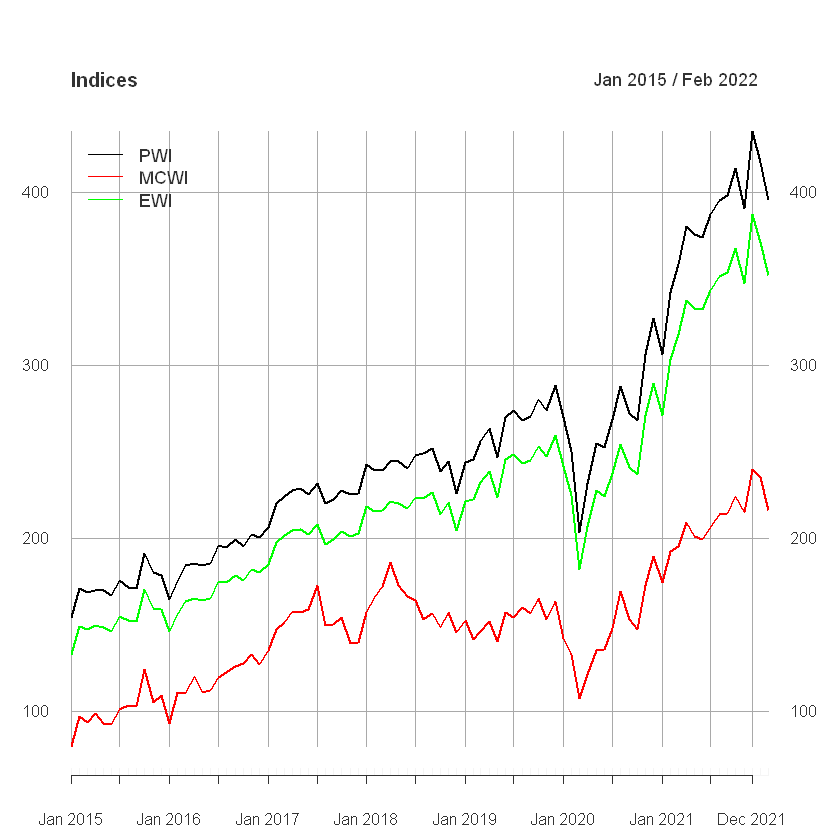

In [161]:
#Merging xts objects with indices together to facilitate plotting
indices <- merge.xts(PWI, MCWI, EWI)
plot_holder <- plot(indices, main = "Indices", col = c("black", "red", "green"))
plot_holder <- addLegend("topleft", on = 0, legend.names = c("PWI", "MCWI", "EWI"), lty=c(1, 1, 1), 
lwd = c(1, 1, 1), col = c("black", "red", "green"))
plot_holder

As far as interpretation of the results goes, in the graph above, we can see huge drops in all of the indices in the beginning of 2020 (beginning of COVID-19 pandemic). What is more interesting, it appears that the price-weighted index dropped the most heavily, followed by the equally-weighted index, and the change in MCWI was slightly less unfavourbale. As we can also observe, the black line (price-weighted index) moved closer to the green one (equally-weighted index) which we may interpret as the fact that stocks with higher prices dropped more than less-priced stocks. Another interesting finding might be that the market-capitalization weighted index dropped the least heavily, therefore, it seems that stocks with high market capitalizaton are supposed to be affected not so strongly as stocks with low market capitalization.

On the other hand, when we focus on the next period (from the drop in the beggining of 2020 to the end of the graph in December 2021), it seems that the price-weighted index increased the most dramatically followed by the equally-weighted index, however, the market-capital weighted portfolio did not increase so significantly. When we take a look at the pre-COVID periods, the indices are believed to behave in a similar way, however, they are somehow shifted. Nevertheless, when we focus on the period starting in the beginning of 2020, the price-weighted and equally-weighted indices seem to increase more steeply than the market-capitalization weighted index. We assume that this behaviour might be due to the unpredicted increase in the level of inflation which does not affect the market-capitalization significantly but prices seem to be affected strongly.